In [1]:
using CSV
using Compose, Cairo, Fontconfig
using DataFrames
using DataFramesMeta
using Dates
using Distributions
using HypothesisTests
using Plots
using Statistics
using StatsPlots

In [2]:
folder = joinpath(@__DIR__(), "data")
vic_trips = CSV.read(joinpath(folder, "Victoria-GTFS\\trips.txt"), DataFrames.DataFrame)
nanaimo = CSV.read(joinpath(folder, "nanaimo_ridership_fall_2023.csv"), DataFrames.DataFrame)
victoria = CSV.read(joinpath(folder, "victoria_ridership_fall_2023.csv"), DataFrames.DataFrame);

In [39]:
first(nanaimo, 5)

5×16 DataFrame
 Row │ route  trip_id   date        planned_start_time  planned_duration_secon ⋯
     │ Int64  Int64     Date        Time                Int64                  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  73449258  2023-10-13  10:30:00                                17 ⋯
   2 │     1  73420181  2023-09-18  10:33:00                                15
   3 │     1  73448776  2023-10-19  18:05:00                                17
   4 │     1  73448308  2023-11-14  18:08:00                                15
   5 │     1  73448889  2023-10-26  16:20:00                                17 ⋯
                                                              12 columns omitted

In [21]:
nanaimo.direction = [(d in ["Inbound", "North", "Clockwise", "East"] ? false : true) for d in nanaimo.direction]
victoria.direction = [(d in ["Inbound", "North", "Clockwise", "East"] ? false : true) for d in victoria.direction];

In [3]:
holidays = [
    Date(2023, 9, 4), # labour day
    Date(2023, 9, 30), # truth and reconciliation
    Date(2023, 10, 9), # thanksgiving
    Date(2023, 11, 11), # remembrance day
]

nanaimo.is_holiday = [date in holidays for date in nanaimo.date]
victoria.is_holiday = [date in holidays for date in victoria.date];

In [4]:
nanaimo.is_weekday = Dates.dayofweek.(nanaimo.date) .< 5
victoria.date = Dates.Date.(victoria.date, dateformat"m/d/y")
victoria.is_weekday = Dates.dayofweek.(victoria.date) .< 5;

In [5]:
nanaimo.primary_delay_seconds = nanaimo.end_delay_seconds - nanaimo.start_delay_seconds
victoria.primary_delay_seconds = victoria.end_delay_seconds - victoria.start_delay_seconds;

In [6]:
nanaimo.primary_delay_pct = nanaimo.primary_delay_seconds ./ nanaimo.planned_duration_seconds
victoria.primary_delay_pct = victoria.primary_delay_seconds ./ victoria.planned_duration_seconds;

In [7]:
nanaimo.trip_long = nanaimo.planned_duration_seconds ./ 60 .> 40
victoria.trip_long = victoria.planned_duration_seconds ./ 60 .> 40;

In [8]:
nanaimo.planned_start_hour = Dates.hour.(nanaimo.planned_start_time)
victoria.planned_start_hour = Dates.hour.(victoria.planned_start_time);
nanaimo[nanaimo.planned_start_hour .== 0, :planned_start_hour] .= 24;
victoria[victoria.planned_start_hour .== 0, :planned_start_hour] .= 24;

In [14]:
# unique(df.route_class)
# unique(df[coalesce.([
#     class in ["Frequent Transit", "Local Transit (Ridership)"] for class in df.route_class
#     ], false), :route])
unique(victoria.direction)
# unique(vic_trips[:, [:trip_headsign, :direction_id]])

7-element Vector{String31}:
 "West"
 "East"
 "Clockwise"
 "Counterclockwise"
 "South"
 "North"
 "Outbound"

In [22]:
nanaimo_wkdy = nanaimo[.!nanaimo.is_holiday .& nanaimo.is_weekday, :];
victoria_wkdy = victoria[.!victoria.is_holiday .& victoria.is_weekday, :];

In [23]:
@show mean(nanaimo_wkdy.primary_delay_seconds) / 60
@show mean(victoria_wkdy.primary_delay_seconds) / 60
@show std(nanaimo_wkdy.primary_delay_seconds) / 60
@show std(victoria_wkdy.primary_delay_seconds) / 60
@show quantile(nanaimo_wkdy.primary_delay_seconds, [0.05, 0.25, 0.5, 0.75, 0.95]) ./ 60
@show quantile(victoria_wkdy.primary_delay_seconds, [0.05, 0.25, 0.5, 0.75, 0.95]) ./ 60;

mean(nanaimo_wkdy.primary_delay_seconds) / 60 = -0.12215451341206628
mean(victoria_wkdy.primary_delay_seconds) / 60 = 1.118025266161232
std(nanaimo_wkdy.primary_delay_seconds) / 60 = 4.248383818881481
std(victoria_wkdy.primary_delay_seconds) / 60 = 4.110649015333647
quantile(nanaimo_wkdy.primary_delay_seconds, [0.05, 0.25, 0.5, 0.75, 0.95]) ./ 60 = [-4.933333333333334, -2.05, -0.43333333333333335, 1.25, 5.5]
quantile(victoria_wkdy.primary_delay_seconds, [0.05, 0.25, 0.5, 0.75, 0.95]) ./ 60 = [-4.25, -1.3833333333333333, 0.6333333333333333, 3.0, 8.066666666666666]


In [24]:
route_time_direction_df = DataFrames.groupby(victoria_wkdy, [:route, :planned_start_hour, :direction]);
# class_time_df = DataFrames.groupby(weekday_df, [:route_class, :planned_start_hour]);
# class_time_direction_df = DataFrames.groupby(weekday_df, [:route_class, :planned_start_hour, :direction]);
# time_direction_df = DataFrames.groupby(weekday_df, [:planned_start_hour, :direction]);

In [28]:
combined_df = combine(
    route_time_direction_df,
    :total_boardings => mean => :ridership_μ,
    :total_boardings => std => :ridership_σ,
    :primary_delay_seconds => mean => :primary_μ,
    :start_delay_seconds => mean => :secondary_μ,
    :primary_delay_seconds => std => :primary_σ,
    :start_delay_seconds => std => :secondary_σ
)
cor_df = unstack(combined_df, [:planned_start_hour, :direction], :route, :ridership_μ);

In [37]:
cor_mat = Matrix(cor_df[:, Not(:planned_start_hour, :direction)])

# Function to compute correlation between two columns, skipping missing values
function safe_cor(x, y)
    mask = .!(ismissing.(x) .| ismissing.(y))
    if sum(mask) < 2
        return 0
    end
    return Statistics.cor(x[mask], y[mask])
end

# Compute the correlation matrix manually
n = size(cor_mat, 2)
corr_matrix = Array{Float64}(undef, n, n)
for i in 1:n
    for j in 1:n
        corr_matrix[i, j] = safe_cor(cor_mat[:, i], cor_mat[:, j])
    end
end

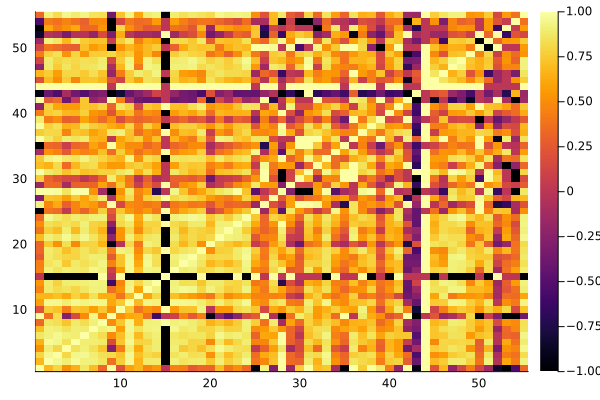

In [38]:
heatmap(corr_matrix)

In [46]:
weekday_adj = weekday_df

for trip in eachrow(weekday_adj)
    for row in eachrow(combined_df)
        if trip.route == row.route && trip.planned_start_hour == row.planned_start_hour && trip.direction == row.direction
            trip.primary_delay_seconds += ceil(max(-row.primary_μ, 0))
        end
    end
end

In [12]:
nx = nanaimo_wkdy.primary_delay_seconds ./ 60
ny = nanaimo_wkdy.start_delay_seconds ./ 60
vx = victoria_wkdy.primary_delay_seconds ./ 60
vy = victoria_wkdy.start_delay_seconds ./ 60;

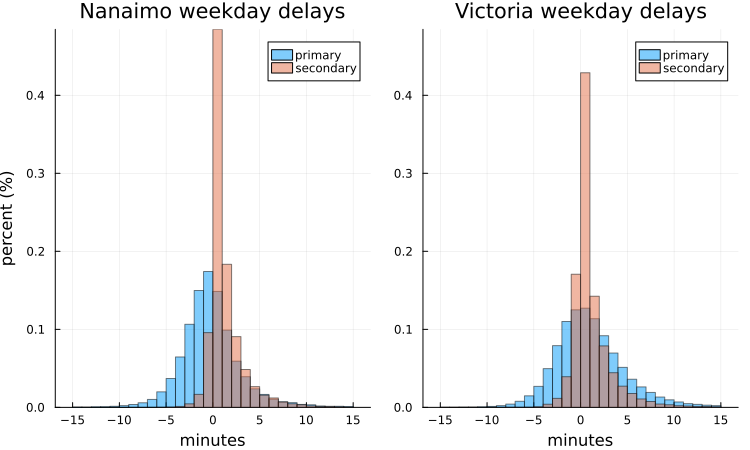

In [13]:
nanaimo_hist = histogram(
    [nx ny],
    bins=range(-15, 15, length=31),
    normalize=true,
    label=["primary" "secondary"],
    alpha=0.5,
    xlabel="minutes",
    ylabel="percent (%)",
    title="Nanaimo weekday delays",
)
victoria_hist = histogram(
    [vx vy],
    bins=range(-15, 15, length=31),
    normalize=true,
    label=["primary" "secondary"],
    alpha=0.5,
    xlabel="minutes",
    ylabel="",
    title="Victoria weekday delays",
)
histplot = plot(nanaimo_hist, victoria_hist,  layout=(1, 2), link=:y, size=(750, 450))
# savefig(histplot, "imgs\\weekday_delay_histogram.png")

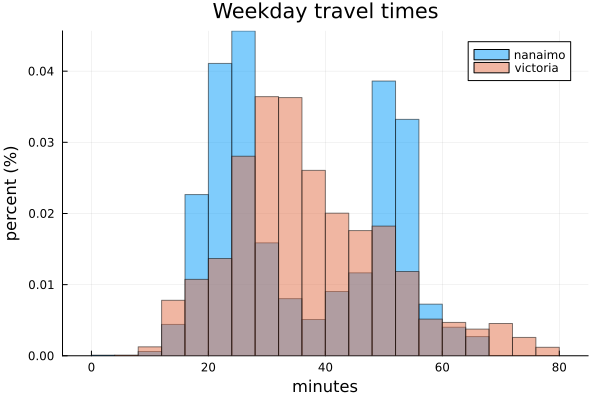

In [19]:
travel_time_hist = histogram(
    nanaimo_wkdy.planned_duration_seconds ./ 60,
    bins=range(0, 80, length=21),
    normalize=true,
    label="nanaimo",
    alpha=0.5,
    xlabel="minutes",
    ylabel="percent (%)",
    title="Weekday travel times",
)
histogram!(
    victoria_wkdy.planned_duration_seconds ./ 60,
    bins=range(0, 80, length=21),
    normalize=true,
    label="victoria",
    alpha=0.5,
)
# savefig(travel_time_hist, "imgs\\weekday_travel_time_histogram.png")

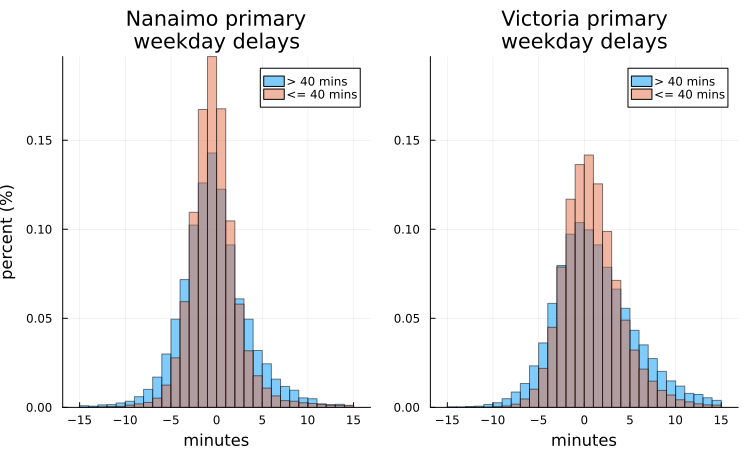

In [47]:
nanaimo_hist = histogram(
    nanaimo_wkdy.primary_delay_seconds[nanaimo_wkdy.trip_long] ./ 60,
    bins=range(-15, 15, length=31),
    normalize=true,
    label="> 40 mins",
    alpha=0.5,
    xlabel="minutes",
    ylabel="percent (%)",
    title="Nanaimo primary\nweekday delays\n",
)
histogram!(
    nanaimo_wkdy.primary_delay_seconds[.!nanaimo_wkdy.trip_long] ./ 60,
    bins=range(-15, 15, length=31),
    normalize=true,
    label="<= 40 mins",
    alpha=0.5,
)
victoria_hist = histogram(
    victoria_wkdy.primary_delay_seconds[victoria_wkdy.trip_long] ./ 60,
    bins=range(-15, 15, length=31),
    normalize=true,
    label="> 40 mins",
    alpha=0.5,
    xlabel="minutes",
    title="Victoria primary\nweekday delays\n",
)
histogram!(
    victoria_wkdy.primary_delay_seconds[.!victoria_wkdy.trip_long] ./ 60,
    bins=range(-15, 15, length=31),
    normalize=true,
    label="<= 40 mins",
    alpha=0.5,
)
histplot = plot(nanaimo_hist, victoria_hist,  layout=(1, 2), link=:y, size=(750, 450))
# savefig(histplot, "imgs\\weekday_travel_time_delay_histogram.png")

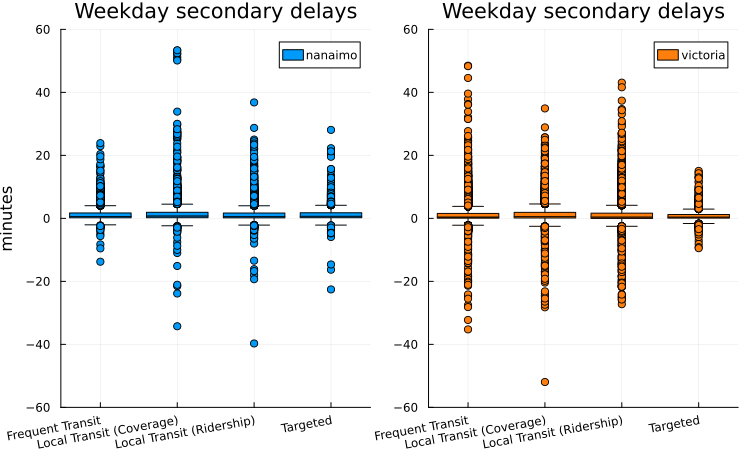

In [139]:
nanaimo_box = @df nanaimo_wkdy[.!ismissing.(nanaimo_wkdy.route_class), :] boxplot(
    :route_class,
    :start_delay_seconds ./ 60,
    ylims=(-60, 60),
    label="nanaimo",
    ylabel="minutes",
    xrotation=10,
)
victoria_box = @df victoria_wkdy[(.!ismissing.(victoria_wkdy.route_class)) .& (victoria_wkdy.route_class .!= "Rapid Transit"), :] boxplot(
    :route_class,
    :start_delay_seconds ./ 60,
    ylims=(-60, 60),
    color=palette(:tab10)[2],
    label="victoria",
    xrotation=10,
)
plotbox = plot(nanaimo_box, victoria_box,  layout=(1, 2), link=:y, size=(750, 450), title="Weekday secondary delays")
# savefig(plotbox, "imgs\\weekday_sdelay_box.png")

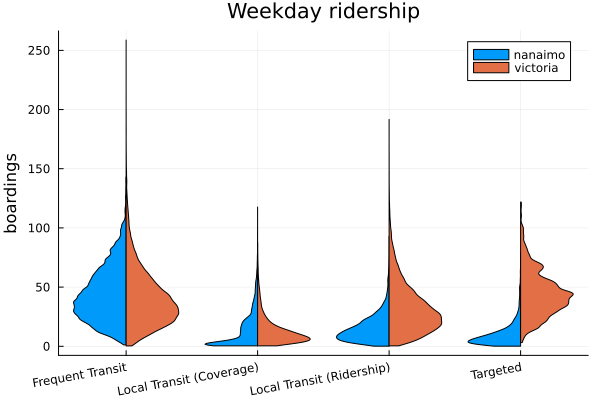

In [44]:
ridership_violin = @df nanaimo_wkdy[.!ismissing.(nanaimo_wkdy.route_class), :] violin(
    :route_class,
    :total_boardings,
    side=:left,
    label="nanaimo",
    ylabel="boardings",
    xrotation=10,
    title="Weekday ridership"
)
@df victoria_wkdy[(.!ismissing.(victoria_wkdy.route_class)) .& (victoria_wkdy.route_class .!= "Rapid Transit"), :] violin!(
    :route_class,
    :total_boardings,
    side=:right,
    label="victoria",
    xrotation=10,
)
# savefig(ridership_violin, "imgs\\weekday_ridership_violin.png")

In [34]:
nanaimo_grouped = DataFrames.groupby(nanaimo_wkdy, :planned_start_hour)
victoria_grouped = DataFrames.groupby(victoria_wkdy, :planned_start_hour)

nanaimo_combined = combine(
    nanaimo_grouped,
    :total_boardings => mean => :ridership_μ,
    :total_boardings => std => :ridership_σ,
    :primary_delay_seconds => mean => :primary_μ,
    :start_delay_seconds => mean => :secondary_μ,
    :primary_delay_seconds => std => :primary_σ,
    :start_delay_seconds => std => :secondary_σ
)
victoria_combined = combine(
    victoria_grouped,
    :total_boardings => mean => :ridership_μ,
    :total_boardings => std => :ridership_σ,
    :primary_delay_seconds => mean => :primary_μ,
    :start_delay_seconds => mean => :secondary_μ,
    :primary_delay_seconds => std => :primary_σ,
    :start_delay_seconds => std => :secondary_σ
);

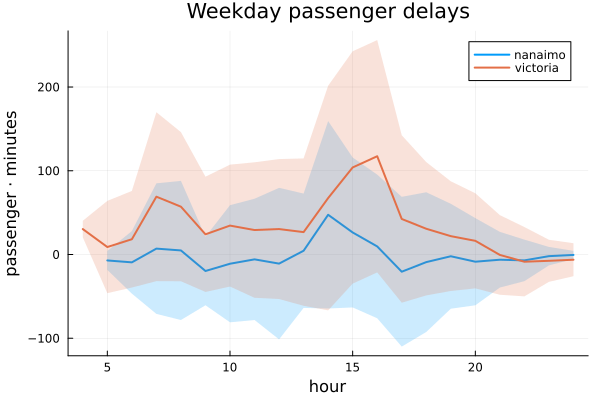

In [41]:
hourly_delay_plot = @df nanaimo_combined plot(
    :planned_start_hour,
    :primary_μ .* :ridership_μ ./ 60,
    ribbon=:primary_σ .* :ridership_σ ./ 60,
    label="nanaimo",
    lw=2,
    fillalpha=0.2,
    xlabel="hour",
    ylabel="passenger ⋅ minutes",
    title="Weekday passenger delays"
)
@df victoria_combined plot!(
    :planned_start_hour,
    :primary_μ .* :ridership_μ ./ 60,
    ribbon=:primary_σ .* :ridership_σ ./ 60,
    label="victoria",
    lw=2,
    fillalpha=0.2,
)
# savefig(hourly_delay_plot, "imgs\\weekday_passenger_delays.png")